<a href="https://colab.research.google.com/github/elizavetalipen/Restaurant-Revenue-Prediction/blob/master/restaurants_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Анализ данных

Датасет содержит следующие колонки: 


*   Город, дату открытия ресторана, размер города и тип ресторана (категориальные)
*   Колонки P1...P37 содержат неизвестные численные данные (коммерческие, демографические)
*   Необходимо предсказать выручку ресторана за год (revenue).

Данная задача является задачей регрессии, существует несколько основных типов моделей, которые обычно применяются для решения этой задачи. 

1. Самым простым случаем является случай линейной регрессии, когда существует линейная связь между некоторыми признаками и целевым признаком. В этом случае существует много моделей для решения задачи. В самом простом случае (если есть линейная зависимость) используют линейную регрессию (Linear Regression), которая оснвана на методе наименьших квадратов. 
2. В случае линейной регрессии также используют Ridge, Lasso и Elastic Net, которые добавляют регуляризацию, это помогает предотвратить переобучение.
3. Дерево решений (Decision Tree) применяется, если зависимости между признаками и целевым признаком являются более сложными. В случае задачи регрессии конечные узлы имеют непрерывные числовые значения.
4. Случайный рес (Random Forest) является объединением нескольких деревьев решений и учитывает более широкий спектр зависимостей между признаками и целевым признаком.
5. Глубокие нейронные сети задействуют множество связанных между собой нейронов для обработки данных и при правильной архитектуре они могут эффективно работать с большими объемами данных и моделировать сложные зависимости.

In [ ]:
!pip install category_encoders
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from category_encoders import TargetEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression


In [ ]:
drive.mount('/content/drive/')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/test.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [ ]:
print(train.isnull().sum().any())
print(test.isnull().sum().any()) 

False
False


In [ ]:
for fname in ["City", "City Group", "Type"]:
  print(fname, len(list(train[fname].unique()))==len(list(test[fname].unique())))

City False
City Group True
Type False


Пропусков в данных нет, но не все категории из Test присутствуют в Train

<AxesSubplot:title={'center':'Mean Revenue Depending on the City'}, xlabel='City'>

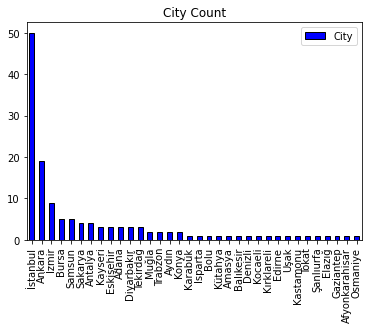

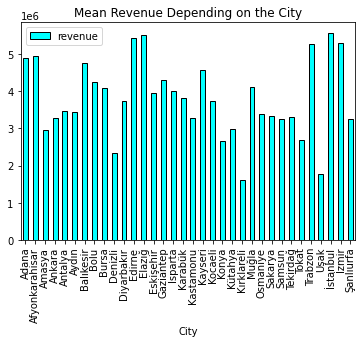

In [ ]:
train["City"].value_counts().to_frame().plot(kind="bar", color = "blue", edgecolor = "black", title="City Count")
citygroup = pd.DataFrame(train.groupby("City")["revenue"].mean())
citygroup.plot(kind="bar", color = "cyan", edgecolor = "black", title="Mean Revenue Depending on the City")

City является категориальной переменной, но городов слишком много, чтобы удобно работать с этими данными. Сам по себе признак City не очень важен, так как датасет уже содержит некоторые признаки с демографической информацией и City Type. Поэтому можно перевести город в численную переменную, равную средней выручке.

In [ ]:
#citygroup = pd.DataFrame(citygroup["revenue"].apply(lambda x: round(x/10**6)))
#citygroup["revenue"] = citygroup["revenue"].apply(lambda x: 'Low' if int(x) in [2,3] else 'Medium' if int(x) in [4,5] else 'High' )
#citydict = citygroup.to_dict()["revenue"]

<AxesSubplot:>

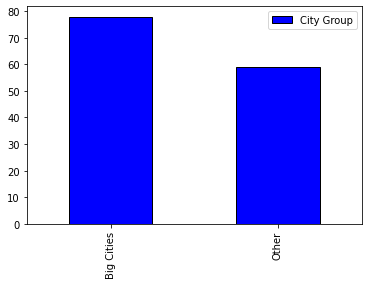

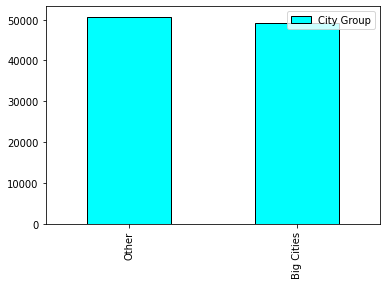

In [ ]:
train["City Group"].value_counts().to_frame().plot(kind="bar", color = "blue", edgecolor = "black")
test["City Group"].value_counts().to_frame().plot(kind="bar", color = "cyan", edgecolor = "black")

<AxesSubplot:>

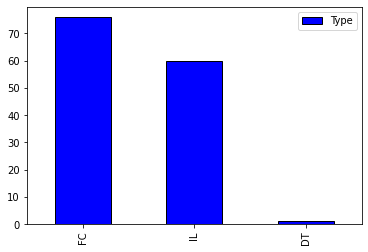

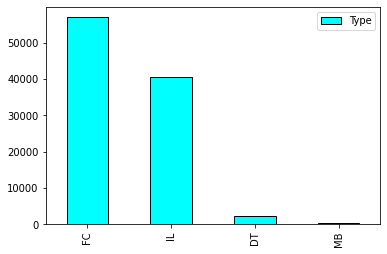

In [ ]:
train["Type"].value_counts().to_frame().plot(kind="bar", color = "blue", edgecolor = "black")
test["Type"].value_counts().to_frame().plot(kind="bar", color = "cyan", edgecolor = "black")

In [ ]:
test.loc[test["Type"] == "MB", "Type"] = "DT"
#test.loc[~test["City"].isin(list(train["City"].unique())), "City"] = "Other"
#citydict["Other"] = "Unknown"

График распределения целевой переменной

Skew: 2.793478695162504 Kurt: 12.055176638707394


<AxesSubplot:ylabel='Frequency'>

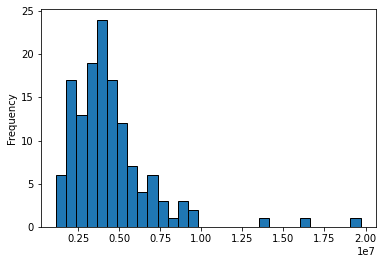

In [ ]:
print("Skew:", train["revenue"].skew(), "Kurt:", train["revenue"].kurt())
train["revenue"].plot(kind="hist", edgecolor = "black", bins=30)

In [ ]:
train = train[train["revenue"] < (1.25 ) * 10**7] # выбросы

Попробуем преобразовать эту колонку, применив логарифмическое, квадратичное, кубическое преобразование

Skew: -0.18792967358381787 Kurt: -0.18426192582195444


<AxesSubplot:title={'center':'Log Transformed'}, ylabel='Frequency'>

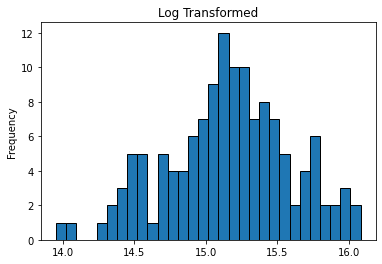

In [ ]:
print("Skew:", train["revenue"].apply(np.log).skew(), "Kurt:", train["revenue"].apply(np.log).kurt())
train["revenue"].apply(np.log).plot(kind="hist", edgecolor = "black", title="Log Transformed", bins=30)

Skew: 0.3685961156363368 Kurt: -0.1305075521388317


<AxesSubplot:title={'center':'Sqrt'}, ylabel='Frequency'>

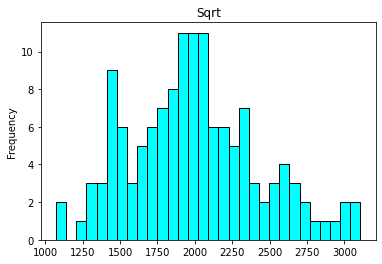

In [ ]:
print("Skew:", train["revenue"].apply(np.sqrt).skew(), "Kurt:", train["revenue"].apply(np.sqrt).kurt())
train["revenue"].apply(np.sqrt).plot(kind="hist", color="cyan", edgecolor = "black", title="Sqrt", bins=30)

Skew: 0.18644662137754398 Kurt: -0.23328303933243077


<AxesSubplot:title={'center':'Cubic'}, ylabel='Frequency'>

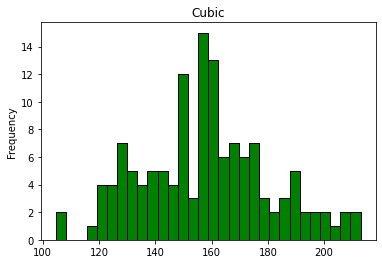

In [ ]:
print("Skew:", train["revenue"].apply(np.cbrt).skew(), "Kurt:", train["revenue"].apply(np.cbrt).kurt())
train["revenue"].apply(np.cbrt).plot(kind="hist", color="green", edgecolor = "black", title="Cubic", bins=30)

Skew: 0   -0.006704
dtype: float64 Kurt: 0   -0.252979
dtype: float64


<AxesSubplot:title={'center':'Power Transformer'}, ylabel='Frequency'>

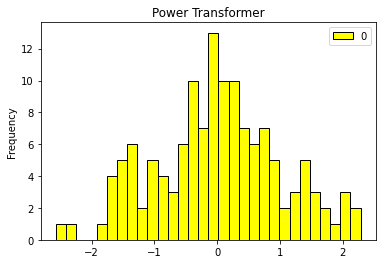

In [ ]:
pt = PowerTransformer(method='box-cox')
data_pt = pd.DataFrame(pt.fit_transform(train[["revenue"]]))
print("Skew:",data_pt.skew(), "Kurt:",data_pt.kurt())
data_pt.plot(kind="hist", color="yellow", edgecolor = "black", title="Power Transformer", bins=30)

Чтобы решить, какое преобразование сработало лучше, можно провести тест Шапиро-Уилка. Нормальное распредление присутствует, если значение p будет не менее 0.05, по результатам видно, что лучше всего подойдет логарифмирование или Power Transformer

In [ ]:
print(shapiro(train["revenue"]))
print(shapiro(train["revenue"].apply(np.log)))
print(shapiro(train["revenue"].apply(np.sqrt)))
print(shapiro(train["revenue"].apply(np.cbrt)))
print(shapiro(data_pt))

ShapiroResult(statistic=0.942127525806427, pvalue=2.2433938283938915e-05)
ShapiroResult(statistic=0.9896738529205322, pvalue=0.42207375168800354)
ShapiroResult(statistic=0.9826950430870056, pvalue=0.0868876501917839)
ShapiroResult(statistic=0.9891507029533386, pvalue=0.37905147671699524)
ShapiroResult(statistic=0.9915498495101929, pvalue=0.6007325649261475)


Из даты открытия ресторана можно выделить год и месяц

In [ ]:
train_cpy = train.copy()
train_cpy["Open Date"] = pd.to_datetime(train_cpy["Open Date"])
train_cpy["Month"] = train_cpy["Open Date"].dt.month
train_cpy["Year"] = train_cpy["Open Date"].dt.year

<AxesSubplot:title={'center':'Year'}>

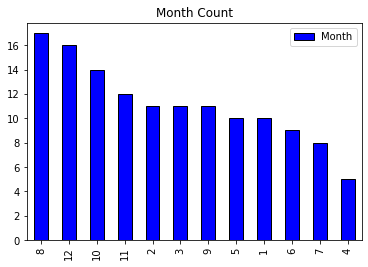

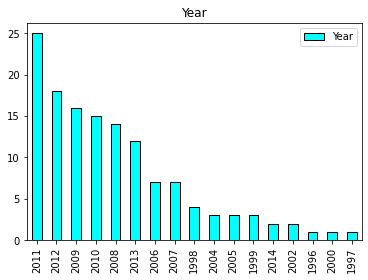

In [ ]:
train_cpy["Month"].value_counts().to_frame().plot(kind="bar", color = "blue", edgecolor = "black", title= "Month Count")
train_cpy["Year"].value_counts().to_frame().plot(kind="bar", color = "cyan", edgecolor = "black", title = "Year")

<AxesSubplot:title={'center':'Mean Revenue Depending on the Year'}, xlabel='Year'>

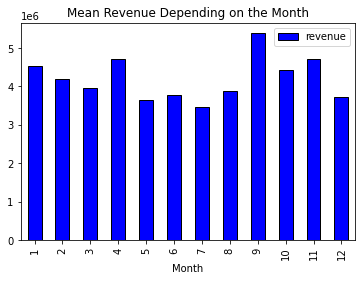

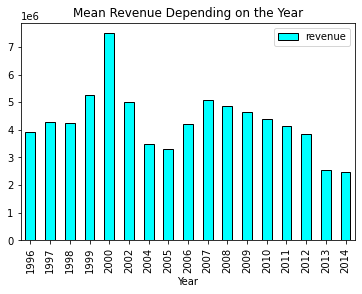

In [ ]:
g1 = pd.DataFrame(train_cpy.groupby("Month")["revenue"].mean())
g1.plot(kind="bar", color = "blue", edgecolor = "black", title="Mean Revenue Depending on the Month")
g2 = pd.DataFrame(train_cpy.groupby("Year")["revenue"].mean())
g2.plot(kind="bar", color = "cyan", edgecolor = "black", title="Mean Revenue Depending on the Year")

Датасет содержит 37 колонок с некоторыми числовыми данными. Посмотрим на корреляцию этих признаков (по умолчанию используется корреляция Пирсона). Впоследствии можно будет избавиться от колонок, которые сильно коррелируют друг с другом. Чем ближе значение к 1 (по модулю), тем больше корреляция

<AxesSubplot:>

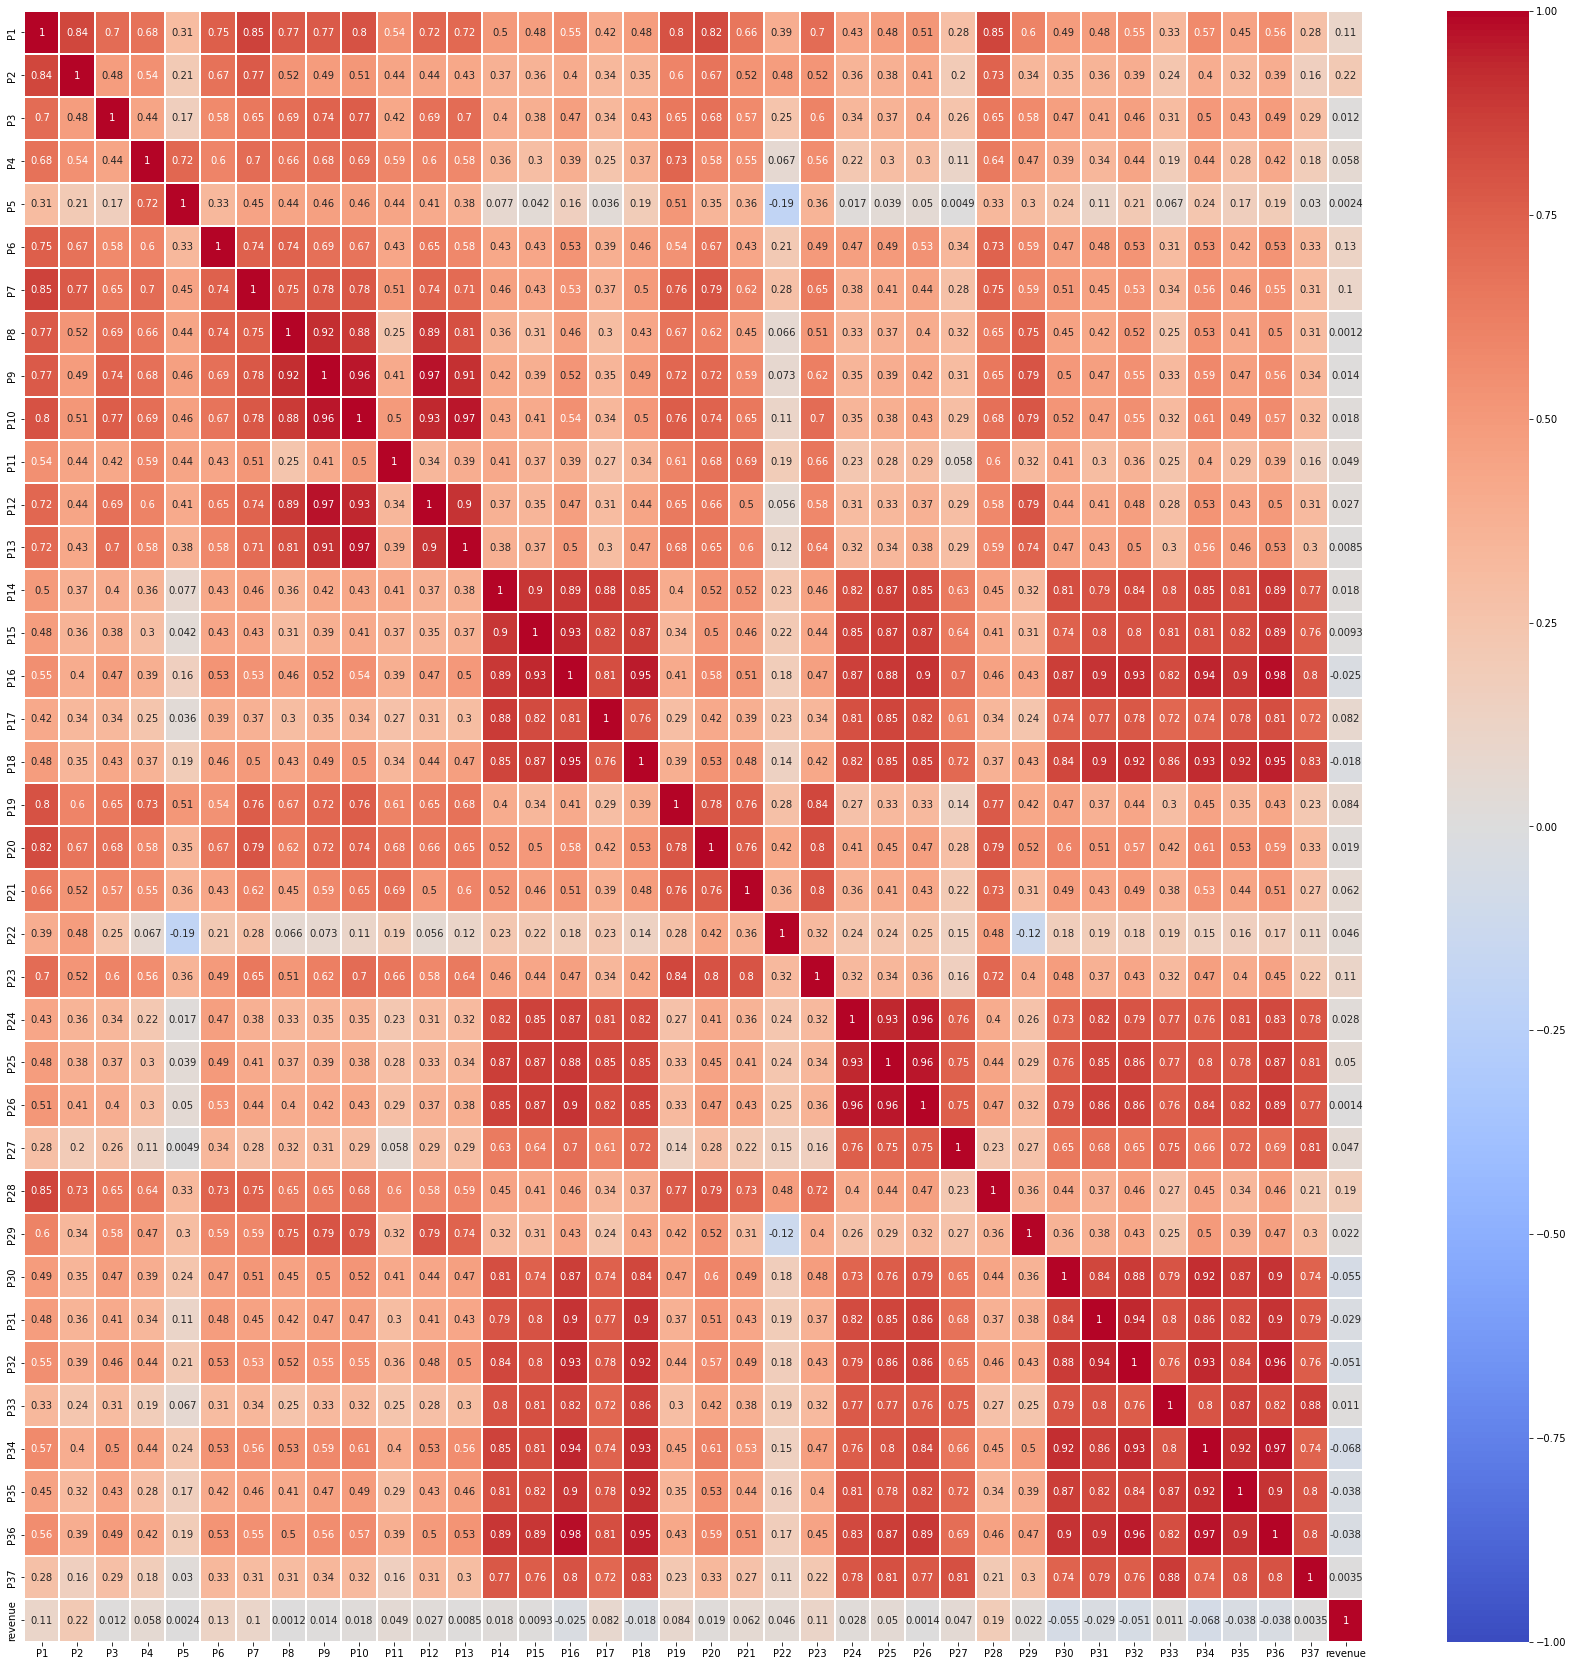

In [ ]:
train_cpy = train_cpy.drop(["Id","Year","Month"], axis=1)
plt.figure(figsize=(30,30)) 
sns.heatmap(train_cpy.corr(),annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=0.3)

Тепловая карта показывает, что нет прямой зависимости между целевым призаком и признаками P1...P37, наиболший коэффициент имеют P1, P2, P6, P7, P23, P28, при этом некоторые признаки P1...P37 сильно коррелируют друг с другом. С помощью тепловой карты можно оценить корреляцию между парами признаков, а для выявления мультиколлинеарности признаков можно вычислить VIF

In [ ]:
correlations = train_cpy.corr()['revenue']
corr_columns = abs(correlations).nlargest(6)[1:].index.tolist()
print(corr_columns) # наиболее коррелирующие с целевой переменной

['P2', 'P28', 'P6', 'P23', 'P1']


In [ ]:
train_cpy.drop(["revenue", "Open Date", "City", 
                "City Group", "Type"], axis=1, inplace=True)

In [ ]:
vif_df = pd.DataFrame()
vif_df["feature"] = train_cpy.columns
# для каждого призанка вычислим значение VIF
vif_df["VIF"] = [variance_inflation_factor(train_cpy.values, i) for i in range(len(train_cpy.columns))]
vif_df

,feature,VIF
0,P1,65.527105
1,P2,62.498177
2,P3,58.643947
3,P4,102.924278
4,P5,16.935098
5,P6,18.704521
6,P7,47.840996
7,P8,163.792709
8,P9,747.918277
9,P10,908.067741


Значение коэффициента больше 5-10 свидетельствует мультиколлинеарности, в данном случае она есть у большинства признаков. Проанализируем значения этих признаков

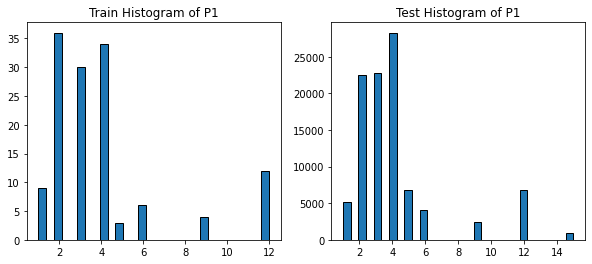

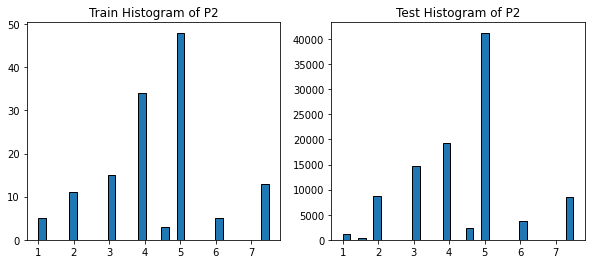

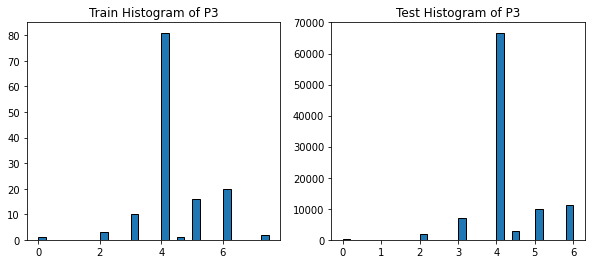

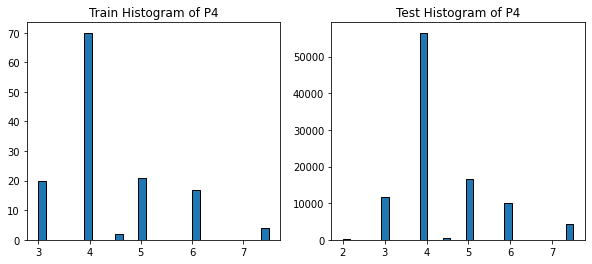

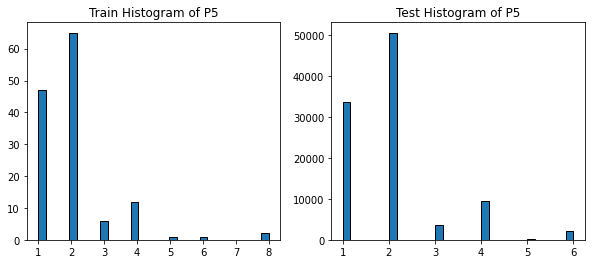

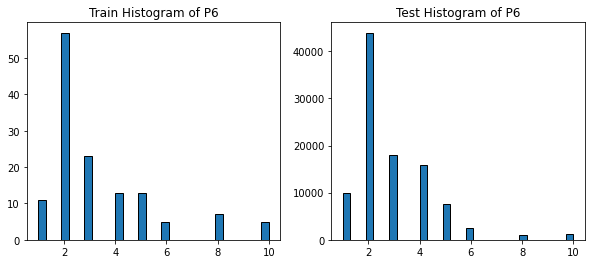

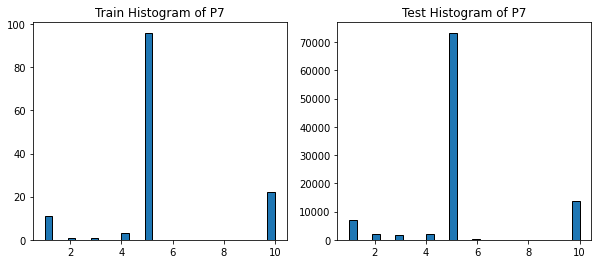

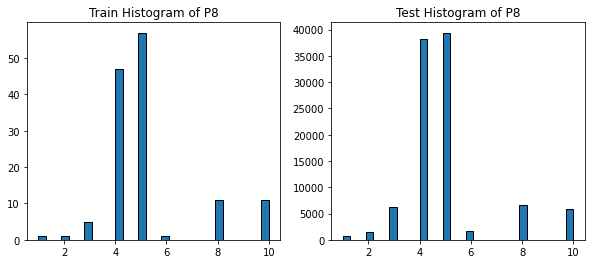

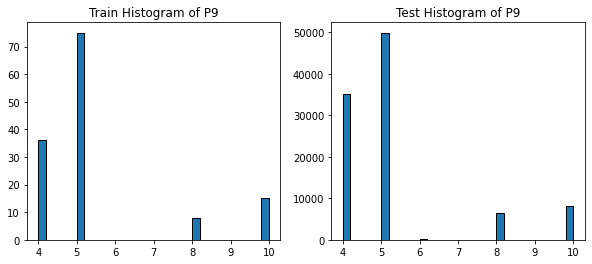

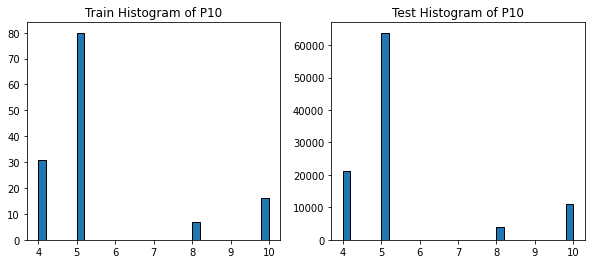

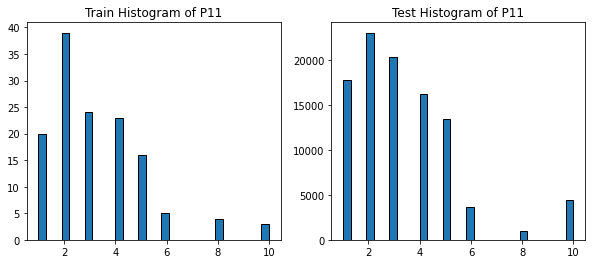

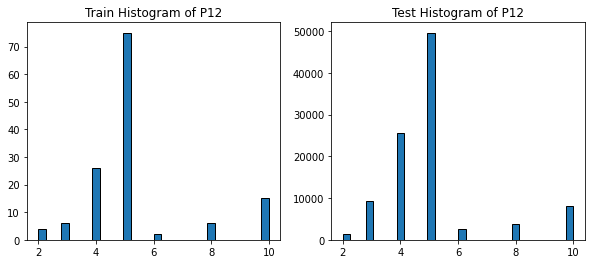

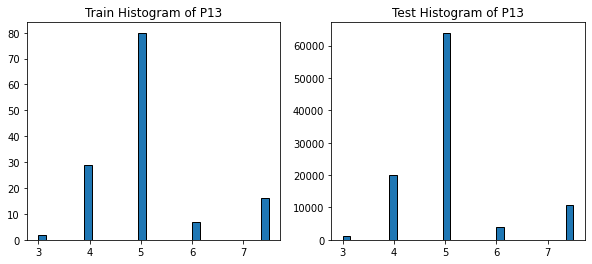

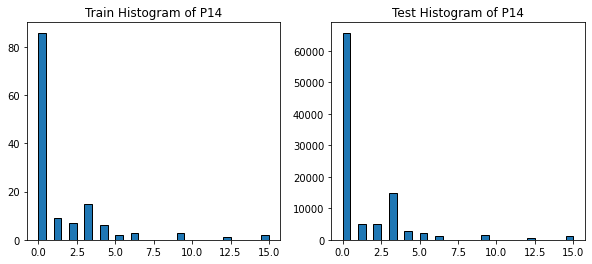

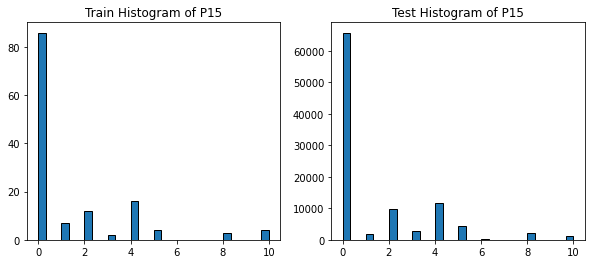

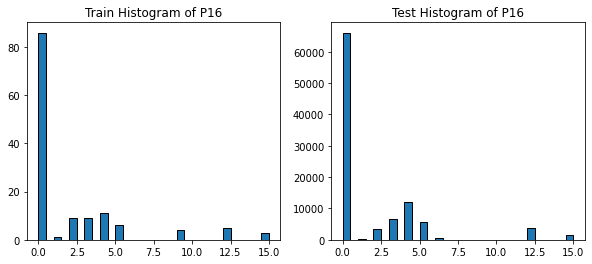

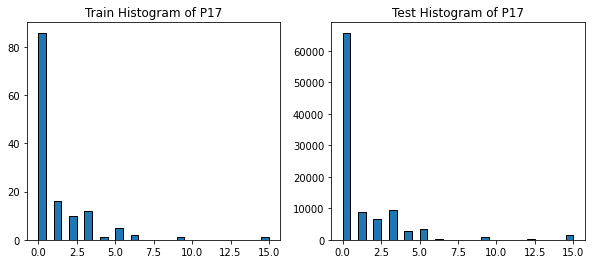

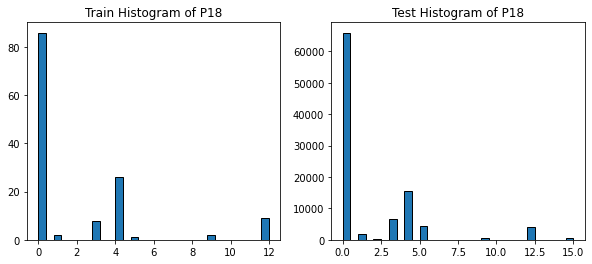

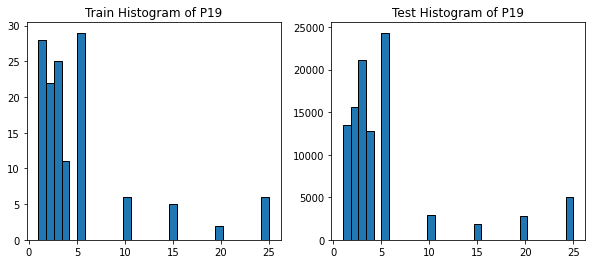

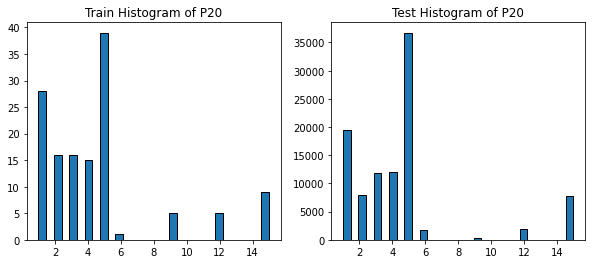

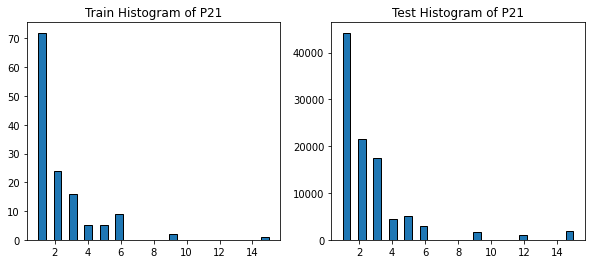

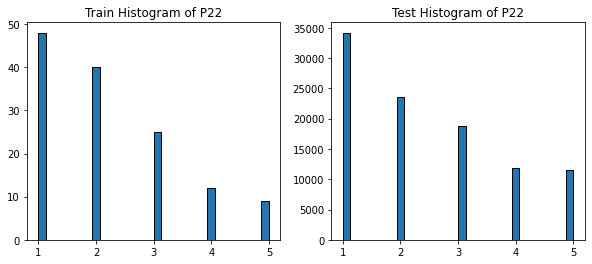

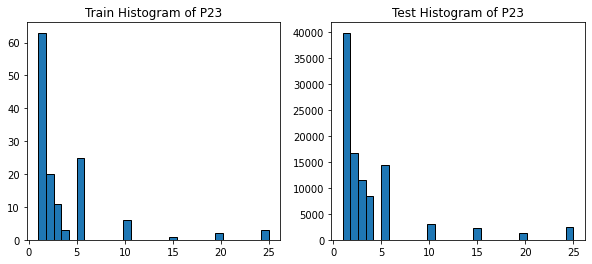

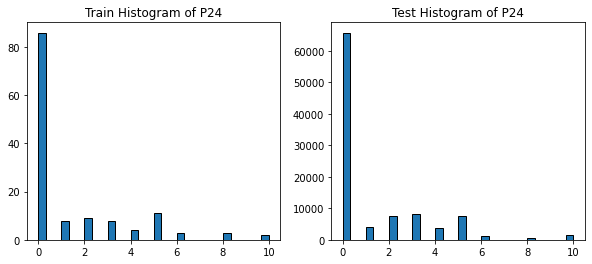

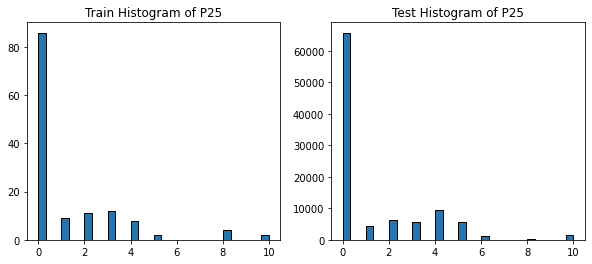

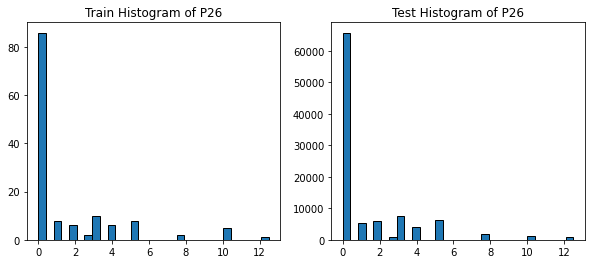

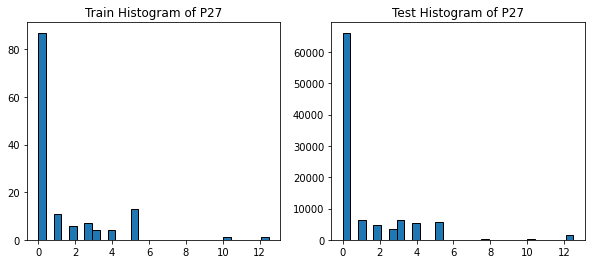

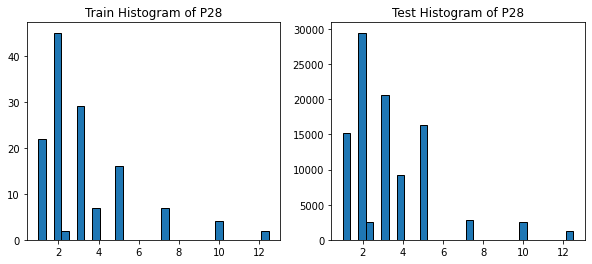

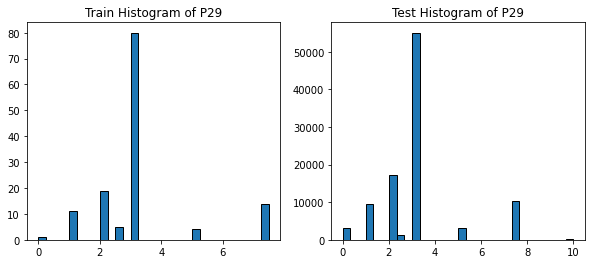

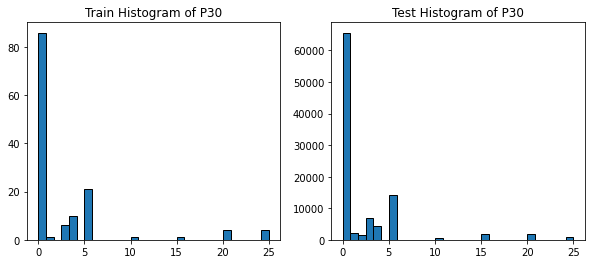

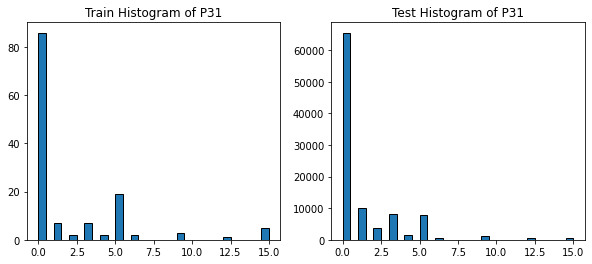

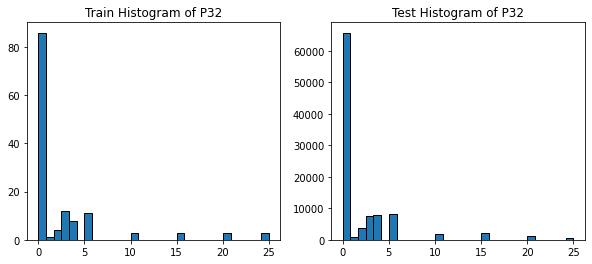

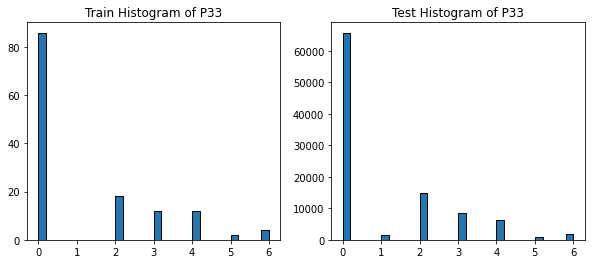

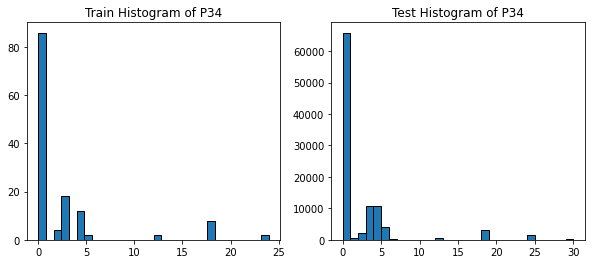

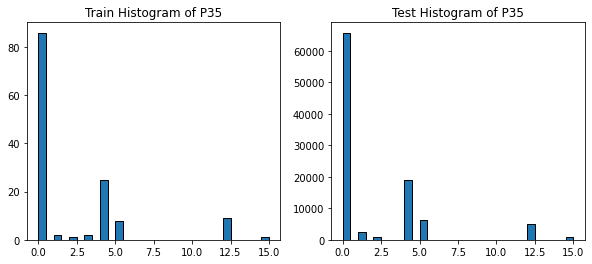

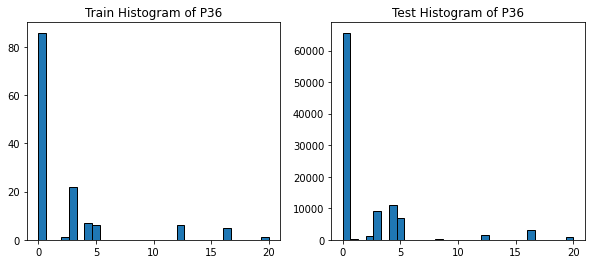

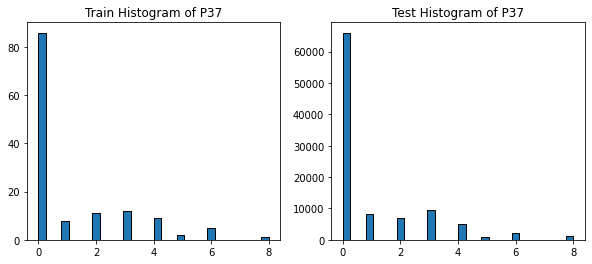

In [ ]:
for i, p in enumerate(train_cpy.columns):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
    ax1.hist(train[p], edgecolor='black', bins=30)
    ax1.set_title(f'Train Histogram of {p}')
    ax2.hist(test[p], edgecolor='black', bins=30)
    ax2.set_title(f'Test Histogram of {p}')
    plt.show()


И в train, и в test в колонках P14-P18, P24-P27, P30-P37 преобладают нулевые значения. Можно предположить, что 0 обозначает неизвестное значение.

In [ ]:
vif_df = vif_df[vif_df["VIF"] > 35]
# дропнем колонки с высоким vif и большим количеством нуевых значений
to_drop = list(vif_df["feature"])
null_cols = [f'P{i}' for i in range (21,22) if f'P{i}']
null_cols += [f'P{i}' for i in range (14,19) if f'P{i}']
null_cols += [f'P{i}' for i in range (24,28) if f'P{i}']
null_cols += [f'P{i}' for i in range (30,38) if f'P{i}']
vif_columns = [f'P{i}' for i in range(1,38) if f'P{i}' not in to_drop+null_cols]

**ANOVA test**

Этот тест сравнивает средние значения нескольких групп.
Чем меньше значение p_value, тем более важным является признак для предсказания, большое значение F-статистики будет указывать на то, что средние значения в каждой группе значительно отличаются

In [ ]:
from scipy.stats import f_oneway

In [ ]:
cols = train_cpy.columns
results, anova_cols = [], []
for col in cols:
    groups = train.groupby(col)['revenue'].apply(list)
    f_stat, p_val = f_oneway(*groups)
    results.append((col, f_stat, p_val))

# Sort the results by p-value in ascending order
results = sorted(results, key=lambda x: x[2])
for col, f_stat, p_val in results:
    print(f"{col}: F-statistic = {f_stat:.2f}, p-value = {p_val:.4f}")
    anova_cols.append(col)


P28: F-statistic = 2.30, p-value = 0.0249
P17: F-statistic = 1.94, p-value = 0.0603
P2: F-statistic = 1.79, p-value = 0.0952
P36: F-statistic = 1.60, p-value = 0.1404
P14: F-statistic = 1.38, p-value = 0.2050
P6: F-statistic = 1.28, p-value = 0.2649
P5: F-statistic = 1.28, p-value = 0.2721
P1: F-statistic = 1.22, p-value = 0.2960
P23: F-statistic = 1.13, p-value = 0.3457
P21: F-statistic = 1.10, p-value = 0.3682
P7: F-statistic = 1.03, p-value = 0.4042
P20: F-statistic = 1.01, p-value = 0.4312
P31: F-statistic = 0.99, p-value = 0.4505
P18: F-statistic = 0.93, p-value = 0.4763
P8: F-statistic = 0.91, p-value = 0.4995
P25: F-statistic = 0.84, p-value = 0.5549
P22: F-statistic = 0.70, p-value = 0.5909
P16: F-statistic = 0.81, p-value = 0.5946
P19: F-statistic = 0.80, p-value = 0.6066
P15: F-statistic = 0.72, p-value = 0.6540
P35: F-statistic = 0.66, p-value = 0.7027
P12: F-statistic = 0.59, p-value = 0.7380
P32: F-statistic = 0.66, p-value = 0.7414
P11: F-statistic = 0.56, p-value = 0.787

**t-test**

Этот тест сравнивает средние значения двух групп

In [ ]:
from scipy.stats import ttest_ind

high_revenue = train[train["revenue"] > train["revenue"].mean()]
low_revenue = train[train["revenue"] <= train["revenue"].mean()]
results, tt_cols = [], []
for col in cols:
      t, p = ttest_ind(high_revenue[col], low_revenue[col])
      results.append((col, t, p))

results.sort(key=lambda x: x[2])
for col, t, p in results:
    print(f'{col}: t={t:.3f}, p={p:.3f}')
    tt_cols.append(col)


P2: t=1.831, p=0.069
P28: t=1.827, p=0.070
P23: t=1.824, p=0.070
P17: t=1.814, p=0.072
P25: t=1.465, p=0.145
P37: t=1.399, p=0.164
P27: t=1.374, p=0.172
P11: t=1.338, p=0.183
P6: t=1.322, p=0.189
P24: t=1.260, p=0.210
P14: t=1.154, p=0.250
P26: t=1.029, p=0.305
P33: t=0.987, p=0.325
P1: t=0.963, p=0.338
P19: t=0.952, p=0.343
P31: t=0.938, p=0.350
P7: t=0.887, p=0.377
P15: t=0.706, p=0.482
P16: t=0.690, p=0.491
P30: t=0.651, p=0.516
P3: t=0.640, p=0.523
P18: t=0.575, p=0.566
P20: t=0.535, p=0.593
P21: t=0.480, p=0.632
P36: t=0.477, p=0.634
P22: t=0.474, p=0.636
P4: t=0.444, p=0.658
P32: t=0.433, p=0.666
P35: t=0.400, p=0.690
P10: t=0.353, p=0.725
P9: t=0.253, p=0.801
P12: t=0.197, p=0.844
P29: t=0.185, p=0.854
P5: t=0.167, p=0.868
P13: t=0.109, p=0.913
P34: t=0.053, p=0.958
P8: t=0.052, p=0.959


In [ ]:
print(corr_columns)
print(vif_columns)
print(anova_cols)
print(tt_cols)

['P2', 'P28', 'P6', 'P23', 'P1']
['P5', 'P6', 'P11', 'P19', 'P20', 'P22', 'P23', 'P28', 'P29']
['P28', 'P17', 'P2', 'P36', 'P14', 'P6', 'P5', 'P1', 'P23', 'P21', 'P7', 'P20', 'P31', 'P18', 'P8', 'P25', 'P22', 'P16', 'P19', 'P15', 'P35', 'P12', 'P32', 'P11', 'P37', 'P26', 'P9', 'P34', 'P4', 'P33', 'P27', 'P10', 'P30', 'P24', 'P13', 'P3', 'P29']
['P2', 'P28', 'P23', 'P17', 'P25', 'P37', 'P27', 'P11', 'P6', 'P24', 'P14', 'P26', 'P33', 'P1', 'P19', 'P31', 'P7', 'P15', 'P16', 'P30', 'P3', 'P18', 'P20', 'P21', 'P36', 'P22', 'P4', 'P32', 'P35', 'P10', 'P9', 'P12', 'P29', 'P5', 'P13', 'P34', 'P8']


#Предобработка данных

Статистические тесты выбали некоторые общие признаки признаки (P28, P2...). 
Модифицируем датасеты исходя из результатов анализа

In [ ]:
def process_data(train: pd.DataFrame, test: pd.DataFrame):

  # преобразование дат
  today = pd.to_datetime("now")
  train["Open Date"] = pd.to_datetime(train["Open Date"])
  train["NMonths"] = (today - train["Open Date"])/np.timedelta64(1, 'M')
  test["Open Date"] = pd.to_datetime(test["Open Date"])
  test["NMonths"] = (today - test["Open Date"])/np.timedelta64(1, 'M')

  # преобразование городов
  target_encoder = TargetEncoder()
  train["CityEnc"] = target_encoder.fit_transform(train["City"], train["revenue"])
  city_mean = train.groupby("City")["CityEnc"].mean().reset_index().rename(columns={"CityEnc": 'CityMean'})
  test = test.merge(city_mean, on="City", how="left")
  test["CityEnc"] = test["CityMean"].fillna(train["CityEnc"].mean())
  test.drop("CityMean", axis=1, inplace=True)

  # преобразование целевой переменной
  pt = PowerTransformer(method='box-cox')
  data_pt = pt.fit_transform(train[["revenue"]])
  train["revenue"] = data_pt

  # преобразование численных данных
  pcols = ["P2", "P6", "P28", "P23"]
  to_drop = [f'P{i}' for i in range(1,38) if f'P{i}' not in pcols]
  #to_drop = []
  #pcols = [f'P{i}' for i in range(1,38) if f'P{i}' not in to_drop] 
  minmaxsc = MinMaxScaler()
  train[pcols + ["NMonths", "CityEnc","revenue"] ] = minmaxsc.fit_transform(train[pcols+ ["NMonths", "CityEnc","revenue"]])
  test[pcols + ["NMonths", "CityEnc"] ] = minmaxsc.fit_transform(test[pcols+ ["NMonths", "CityEnc"]])

  train.drop(to_drop+["Id", "Open Date", "City"], axis=1, inplace=True)
  test.drop(to_drop+["Id", "Open Date", "City"], axis=1, inplace=True)
  
  return pd.get_dummies(train), pd.get_dummies(test)


In [ ]:
train, test = process_data(train, test)

In [ ]:
train.tail()

,P2,P6,P23,P28,revenue,NMonths,CityEnc,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL
132,0.307692,0.111111,0.000000,0.086957,0.727693,0.315253,0.543754,0,1,0,1,0
133,0.615385,0.222222,0.000000,0.173913,0.977232,0.411374,0.654795,1,0,0,1,0
134,0.461538,0.222222,0.041667,0.086957,0.334286,0.426209,0.454083,0,1,0,1,0
135,0.615385,0.111111,0.000000,0.173913,0.842525,0.182970,1.000000,1,0,0,1,0
136,0.615385,0.111111,0.000000,0.173913,0.776509,0.248339,1.000000,1,0,0,1,0


#Построение модели и подбор параметров

In [ ]:
X = train.drop(["revenue"], axis=1)
y = train["revenue"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

##Keras DNN

In [ ]:
params = {"units1": 64,
          "units2": 32,
          "units3": 16,
          "units4": 8,
          "epochs": 1000,
          "bsize": 20,
          "activation": "relu",
          "loss": "mean_squared_error",
          "metrics": ["mae","mse"],
          "dropout": 0.2,
          "optimizer": "adam",
          "dim": X_train.shape[1]}

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.legend()


def plot_results(y_test, predictions, modelname:str):
  plt.scatter(y_test, predictions)
  grid = np.linspace(y_test.min(), y_test.max(), 1000)
  plt.plot(grid, grid, "--k")
  plt.title = modelname
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  

In [ ]:
def create_best_model(best_params):
    """ This function creates a model with given hyperparameters"""

    model = Sequential()
    model.add(Dense(units=best_params["units1"], activation="relu", 
                    input_dim=best_params["dim"]))
    model.add(Dropout(best_params["dropout"]))
    model.add(Dense(units=best_params["units2"], activation="relu"))
    model.add(Dense(units=best_params["units2"], activation="relu"))
    model.add(Dropout(best_params["dropout"]))
    model.add(Dense(units=best_params["units3"], activation="relu"))
    model.add(Dense(units=best_params["units4"], activation="relu"))
    model.add(Dense(units=1, activation="linear"))
    model.compile(loss=best_params["loss"], 
                  optimizer=best_params["optimizer"], metrics=[best_params["metrics"]])
    return model


def train_model(params, model):
  """ This function performs model training and returns predictions"""

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

  history = model.fit(X_train, y_train,  validation_data=(X_test, y_test), 
                      epochs=params["epochs"], batch_size=params["bsize"], 
                       validation_split = 0.2, callbacks=[early_stop])
  scores = model.evaluate(X_test, y_test) 
  y_pred = model.predict(X_test)
  plot_loss(history)
  return y_pred


def estimate_model(y_test, predictions, modelname: str):
  """ This function applies metrics to estimate the model performance """

  model_mse = mean_squared_error(y_test, predictions)
  model_mae = mean_absolute_error(y_test, predictions)
  model_mape = mean_absolute_percentage_error(y_test, predictions)
  model_r2 = r2_score(y_test, predictions)
  plot_results(y_test, predictions, modelname)
  return pd.DataFrame({"ANN Model": modelname, "R2": model_r2, "MAE": model_mae, 
                       "MSE": model_mse, "MAPE": model_mape}, index=[0])



In [ ]:
model1 = create_best_model(params)

Epoch 1/1000
5/5 [==============================] - 1s 58ms/step - loss: 0.3365 - mae: 0.5388 - mse: 0.3365 - val_loss: 0.2413 - val_mae: 0.4487 - val_mse: 0.2413
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.2804 - mae: 0.4859 - mse: 0.2804 - val_loss: 0.1942 - val_mae: 0.3967 - val_mse: 0.1942
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2236 - mae: 0.4226 - mse: 0.2236 - val_loss: 0.1468 - val_mae: 0.3364 - val_mse: 0.1468
Epoch 4/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1582 - mae: 0.3461 - mse: 0.1582 - val_loss: 0.0967 - val_mae: 0.2659 - val_mse: 0.0967
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1166 - mae: 0.2818 - mse: 0.1166 - val_loss: 0.0533 - val_mae: 0.1909 - val_mse: 0.0533
Epoch 6/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0717 - mae: 0.2206 - mse: 0.0717 - val_loss: 0.0354 - val_mae: 0.1354 - val_mse: 0.0354
Epoch 7/1000
5/5 [====

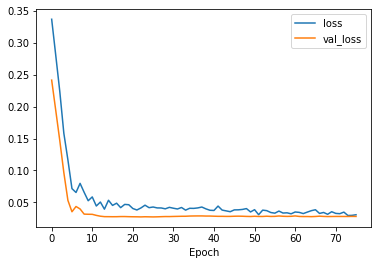

In [ ]:
pred1 = train_model(params, model1)

,ANN Model,R2,MAE,MSE,MAPE
0,Keras DNN,0.275756,0.133298,0.028151,0.56076


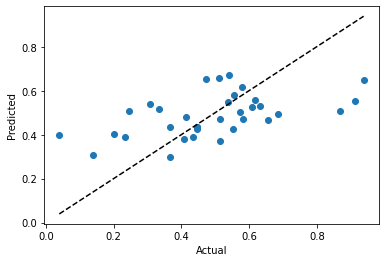

In [ ]:
est1 = estimate_model(y_test, pred1, "Keras DNN")
est1

##Decision Tree

In [ ]:
models = {"Decision Tree": DecisionTreeRegressor(),
          "XGBoost": XGBRegressor(), "RandomForest": RandomForestRegressor()}

In [ ]:
tree_params = {'max_depth': [3, 5, 7],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', None],
              'random_state': [42],
              'criterion': ['absolute_error','squared_error'],
              'splitter': ['best', 'random'],
              'min_weight_fraction_leaf': [0.0, 0.1, 0.2]}

def train_best_model(param_grid:dict, modelname:str, scor:str):
  model = models[modelname]
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scor)
  grid_search.fit(X_train, y_train)
  params = grid_search.best_params_
  best_model = grid_search.best_estimator_
  best_model.fit(X_train, y_train)
  y_pred = best_model.predict(X_test)
  return y_pred


/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-pa

,ANN Model,R2,MAE,MSE,MAPE
0,Decision Tree,0.215388,0.130428,0.030498,0.601044


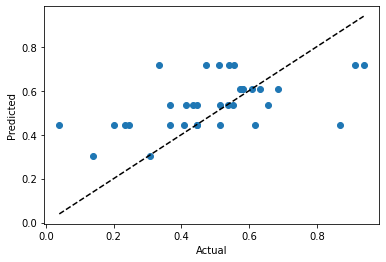

In [ ]:
pred2 = train_best_model(tree_params, "Decision Tree", "r2")
est2 = estimate_model(y_test, pred2, "Decision Tree")
est2

##XGB

Градиентный бустинг можно использовать для задачи регрессии. Его суть заключается в том, что строится последовательность моделей, каждая из которых пытается исправить ошибки предыдущей модели. Таким образом, модель улучшается с каждой последующей итерацией (до определенного момента). XGBoost использует в качестве базовых моделей деревья решений, где для обучения каждого дерева используется градиентный спуск

In [ ]:
xgb_params = {
    'max_depth': [3, 5, 7, 9],
    'alpha': [1, 3, 5],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]}

,ANN Model,R2,MAE,MSE,MAPE
0,XGBoost,0.294553,0.137004,0.02742,0.581561


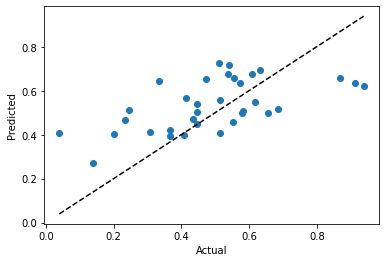

In [ ]:
pred3 = train_best_model(xgb_params, "XGBoost", "r2")
est3 = estimate_model(y_test, pred3, "XGBoost")
est3

##Random Forest

,ANN Model,R2,MAE,MSE,MAPE
0,RandomForest,0.227479,0.140315,0.030028,0.598086


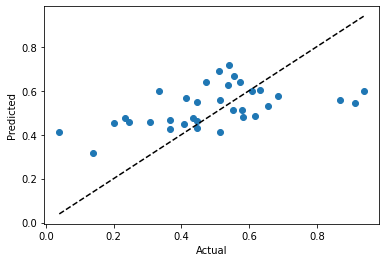

In [ ]:
forest_params = {'n_estimators': [100, 500, 1000],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [10, 20, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

pred4 = train_best_model(forest_params, "RandomForest", "neg_mean_squared_error")
est4 = estimate_model(y_test, pred4, "RandomForest")
est4              


##Итоги

In [ ]:
pd.concat([est1,est2,est3,est4])

,ANN Model,R2,MAE,MSE,MAPE
0,Keras DNN,0.275756,0.133298,0.028151,0.560760
0,Decision Tree,0.215388,0.130428,0.030498,0.601044
0,XGBoost,0.294553,0.137004,0.027420,0.581561
0,RandomForest,0.227479,0.140315,0.030028,0.598086


Все модели показали примерно одинаковые результаты, лучше всего сработали Keras сеть и XGBoost. Чтобы улучшить результаты, нужно попробовать другие способы обрабоки исходных данных и другие архитектуры моделей, в том числе подобрать оптимальные параметры для keras, также увеличение размера тренировачного датасета улучшит работу моделей.